<a href="https://colab.research.google.com/github/c-c-c-c/yolov3_trial/blob/master/yolo_v3_colab_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv3 × Tensor Flow


In [1]:
!git clone https://github.com/c-c-c-c/yolov3_trial

Cloning into 'yolov3_trial'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 52 (delta 4), reused 51 (delta 3), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [2]:
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=19hHTSpXLYqMXwhdETJ6H9BPsw_pe67c9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19hHTSpXLYqMXwhdETJ6H9BPsw_pe67c9" -O yolov3_trial/keras-yolo3/model_data/yolo.h5 && rm -rf /tmp/cookies.txt

--2020-08-26 01:35:27--  https://drive.google.com/uc?export=download&confirm=J8yK&id=19hHTSpXLYqMXwhdETJ6H9BPsw_pe67c9
Resolving drive.google.com (drive.google.com)... 108.177.127.100, 108.177.127.101, 108.177.127.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.127.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3o-docs.googleusercontent.com/docs/securesc/7gvnhd9oj2jensovdiui8qcjkt9miueo/m4ljaapogjfdtn3dobikmun9rualjpg7/1598405700000/01278531181409410460/13217000440693018302Z/19hHTSpXLYqMXwhdETJ6H9BPsw_pe67c9?e=download [following]
--2020-08-26 01:35:28--  https://doc-00-3o-docs.googleusercontent.com/docs/securesc/7gvnhd9oj2jensovdiui8qcjkt9miueo/m4ljaapogjfdtn3dobikmun9rualjpg7/1598405700000/01278531181409410460/13217000440693018302Z/19hHTSpXLYqMXwhdETJ6H9BPsw_pe67c9?e=download
Resolving doc-00-3o-docs.googleusercontent.com (doc-00-3o-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
C

In [3]:
%cd yolov3_trial/keras-yolo3/

/content/yolov3_trial/keras-yolo3


In [4]:
!pip3 uninstall keras -y
!pip install keras==2.3.1
!pip3 uninstall tensorflow -y
!pip install tensorflow==1.15.2



Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 378kB 8.2MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 110.5MB 59kB/s 
     |████████████████████████████████| 3.8MB 42.9MB/s 
     |████████████████████████████████| 512kB 36.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=6b12c8f7d6a6afb56fdd0ce8a5b0da57baec4c1d6e9a2670695803de32a89b64
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard

In [11]:
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt

import sys
sys.path.append('../library/keras_yolo3/')

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

class YOLO(object):
    _defaults = {
        "model_path": 'model_data/yolo.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/coco_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        
        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        return image

    def close_session(self):
        self.sess.close()

# def detect_video(yolo, video_path, output_path=""):
#     import cv2
#     vid = cv2.VideoCapture(video_path)
#     if not vid.isOpened():
#         raise IOError("Couldn't open webcam or video")
#     video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
#     video_fps       = vid.get(cv2.CAP_PROP_FPS)
#     video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
#                         int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
#     isOutput = True if output_path != "" else False
#     if isOutput:
#         print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
#         out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
#     accum_time = 0
#     curr_fps = 0
#     fps = "FPS: ??"
#     prev_time = timer()
#     while True:
#         return_value, frame = vid.read()
#         image = Image.fromarray(frame)
#         image = yolo.detect_image(image)
#         result = np.asarray(image)
#         curr_time = timer()
#         exec_time = curr_time - prev_time
#         prev_time = curr_time
#         accum_time = accum_time + exec_time
#         curr_fps = curr_fps + 1
#         if accum_time > 1:
#             accum_time = accum_time - 1
#             fps = "FPS: " + str(curr_fps)
#             curr_fps = 0
#         cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
#                     fontScale=0.50, color=(255, 0, 0), thickness=2)
#         cv2.namedWindow("result", cv2.WINDOW_NORMAL)
#         cv2.imshow("result", result)
#         if isOutput:
#             out.write(result)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#     yolo.close_session()





In [8]:
def detect_img(image):

    yolo = YOLO()
    
    r_image = yolo.detect_image(image)
    print(type(r_image))
    plt.imshow(r_image)


model_data/yolo.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 4 boxes for img
dog 0.94 (351, 244) (456, 345)
dog 0.99 (135, 195) (283, 355)
person 0.99 (397, 39) (524, 354)
person 1.00 (494, 99) (587, 348)
3.5340891300000408
<class 'PIL.JpegImagePlugin.JpegImageFile'>


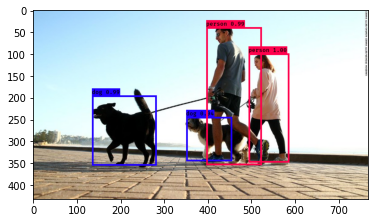

In [12]:
image = Image.open("../images/walk.jpg")
detect_img(image)